In [613]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from sklearn.linear_model import LogisticRegression

## Basic Overview
This database is a collection of labeled tweets. For some reason at first it didn't have any column names assinged so I had to do it myself. It contains:
- **id**: A unique identifier for a tweet.
- **category**: From my understanding it's a subject that a particular tweet reffers to.
- **type**: There are four types of messages: Positive, Negative, Irrelevant and Neutral. Author mentioned that messages that are not relevant to the category are regarded as Neutral (I decided that I won't make that distinction and I'll try to predict Irrelevant messages also).
- **text**: A content of a tweet.

Author gives this data in two files. The first is for training a model (74682 entries) and the second one is for testing (1000 entries). Unfortunately there isn't any information about how this data was labeled and upon further inspection I started to have doubts if labeling was executed right.

In [614]:
test_df = pd.read_csv('twitter_validation.csv', header=None)
train_df = pd.read_csv('twitter_training.csv', header=None)

In [615]:
test_df.columns = ['id', 'category', 'type', 'text']

In [616]:
test_df.head()

,id,category,type,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [617]:
train_df.columns = ['id', 'category', 'type', 'text']

In [618]:
train_df.head()

,id,category,type,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


### Missing Data
It turns out that train dataset contains missing values in text column. I deleted those entries. The test dataset seems to be okey.

In [619]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        74682 non-null  int64 
 1   category  74682 non-null  object
 2   type      74682 non-null  object
 3   text      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [620]:
train_df.isnull().sum()

id            0
category      0
type          0
text        686
dtype: int64

In [621]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1000 non-null   int64 
 1   category  1000 non-null   object
 2   type      1000 non-null   object
 3   text      1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [622]:
train_df.dropna(inplace=True, axis=0)

In [623]:
train_df.isnull().sum()

id          0
category    0
type        0
text        0
dtype: int64

### Categories
Both sets contain the same categories which are listed below.

In [624]:
distinct_categories_train = train_df['category'].unique()
distinct_categories_val = test_df['category'].unique()

categories_train_set = set(distinct_categories_train)
categories_val_set = set(distinct_categories_val)

print(categories_train_set == categories_val_set)

True


In [625]:
categories_train_set

{'Amazon',
 'ApexLegends',
 'AssassinsCreed',
 'Battlefield',
 'Borderlands',
 'CS-GO',
 'CallOfDuty',
 'CallOfDutyBlackopsColdWar',
 'Cyberpunk2077',
 'Dota2',
 'FIFA',
 'Facebook',
 'Fortnite',
 'Google',
 'GrandTheftAuto(GTA)',
 'Hearthstone',
 'HomeDepot',
 'LeagueOfLegends',
 'MaddenNFL',
 'Microsoft',
 'NBA2K',
 'Nvidia',
 'Overwatch',
 'PlayStation5(PS5)',
 'PlayerUnknownsBattlegrounds(PUBG)',
 'RedDeadRedemption(RDR)',
 'TomClancysGhostRecon',
 'TomClancysRainbowSix',
 'Verizon',
 'WorldOfCraft',
 'Xbox(Xseries)',
 'johnson&johnson'}

### Distribution of Emotion
Distribution of emotion (type column) in both sets seem to be similiar.

In [626]:
train_df['type'].value_counts()

type
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

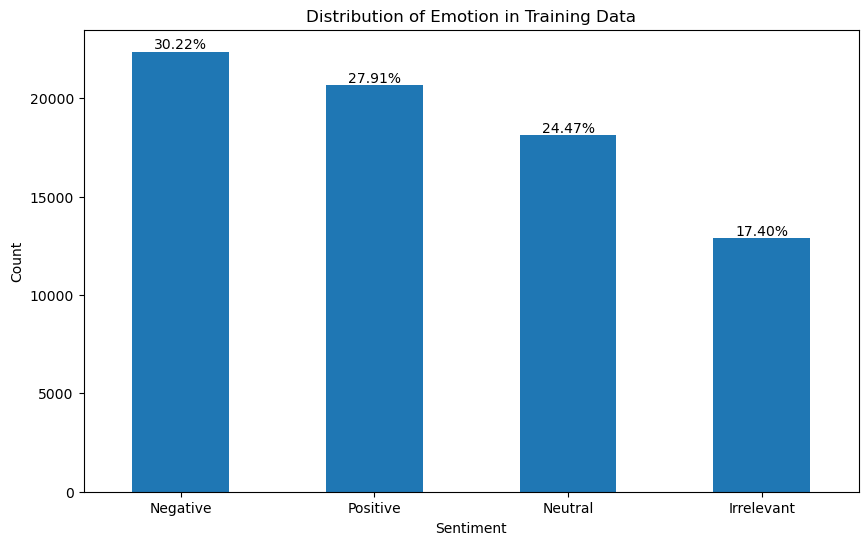

In [627]:
plt.figure(figsize=(10, 6))
train_df['type'].value_counts().plot(kind='bar')

total_samples_train = len(train_df)
for i, count in enumerate(train_df['type'].value_counts()):
    percentage = (count / total_samples_train) * 100
    plt.text(i, count, f'{percentage:.2f}%', ha='center', va='bottom')
    
plt.title('Distribution of Emotion in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [628]:
test_df['type'].value_counts()

type
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: count, dtype: int64

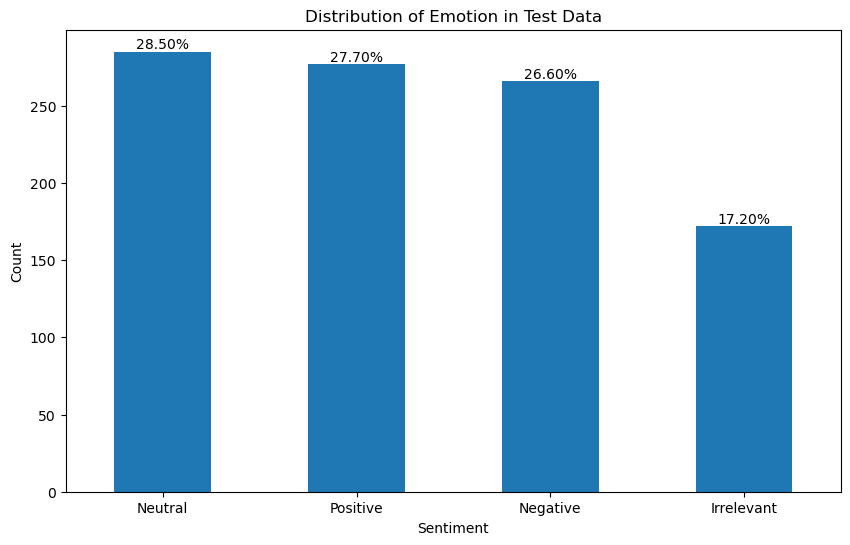

In [629]:
plt.figure(figsize=(10, 6))
test_df['type'].value_counts().plot(kind='bar')

total_samples_test = len(test_df)
for i, count in enumerate(test_df['type'].value_counts()):
    percentage = (count / total_samples_test) * 100
    plt.text(i, count, f'{percentage:.2f}%', ha='center', va='bottom')

plt.title('Distribution of Emotion in Test Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Text Length
Tweet lengths in both data set are about right. Whats worth noting is that the text isn't perfect - there are sometimes weird (they seem to appear without context), not alphanumeric characters. Additionally there are a few outliers in the training set.

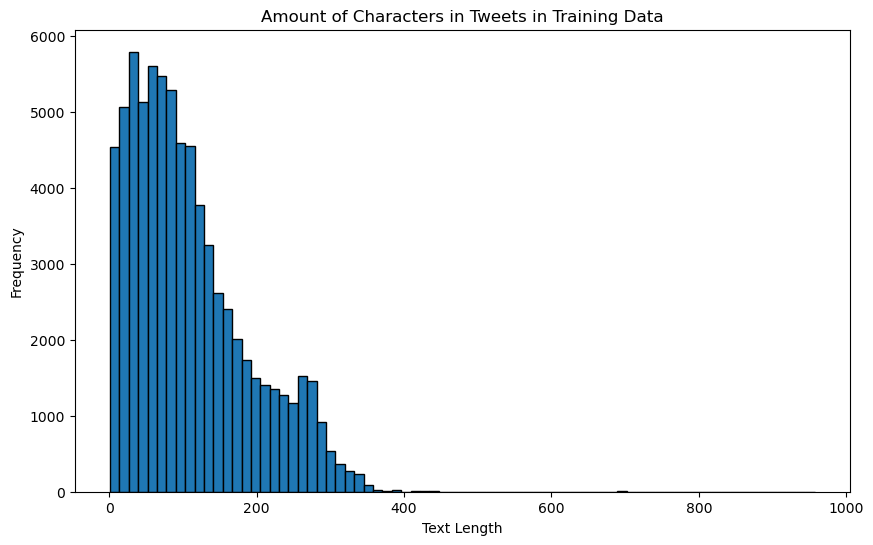

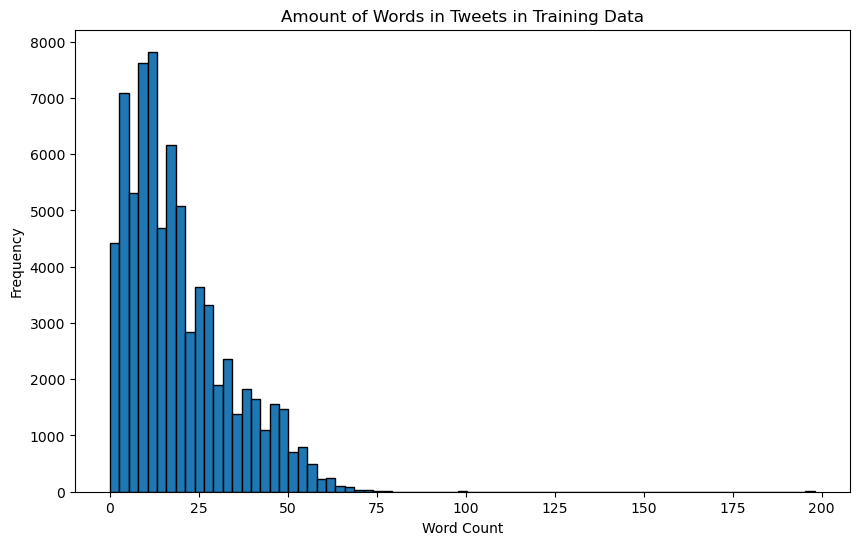

In [630]:
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
plt.hist(train_df['text_length'], bins=75, edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Amount of Characters in Tweets in Training Data')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(train_df['word_count'], bins=75, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Amount of Words in Tweets in Training Data')
plt.show()

In [631]:
print("Mean word count:", train_df['word_count'].mean())
print("Mean text length:", train_df['text_length'].mean())

Mean word count: 19.226620357857183
Mean text length: 108.78365046759285


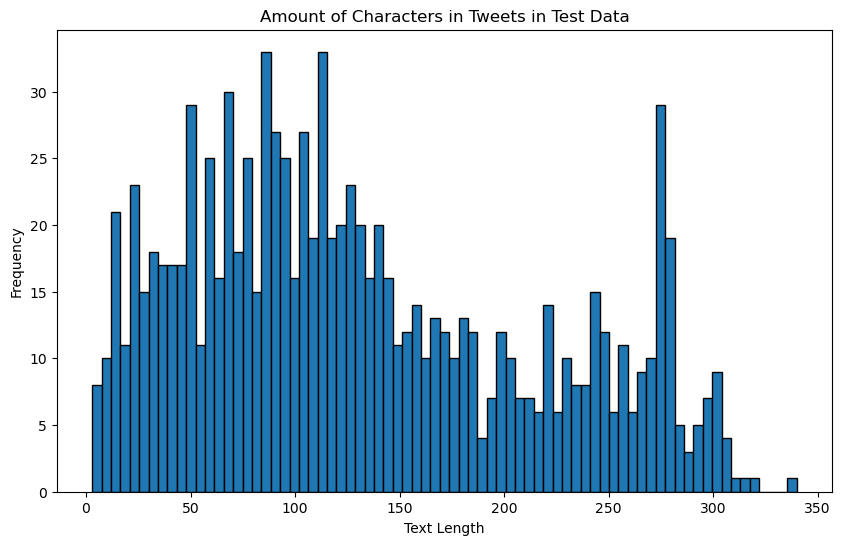

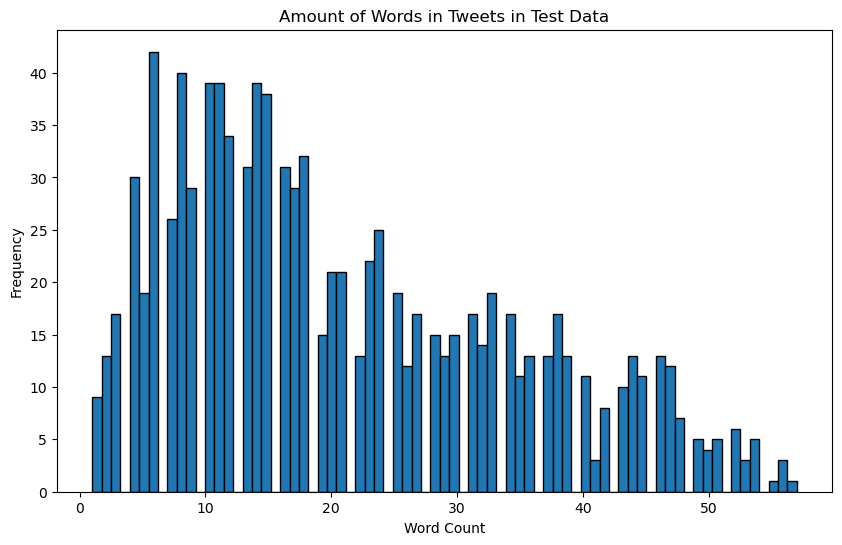

In [632]:
test_df['text_length'] = test_df['text'].apply(len)
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(test_df['text_length'], bins=75, edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Amount of Characters in Tweets in Test Data')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(test_df['word_count'], bins=75, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Amount of Words in Tweets in Test Data')
plt.show()

In [633]:
print("Mean word count:", test_df['word_count'].mean())
print("Mean text length:", test_df['text_length'].mean())

Mean word count: 20.94
Mean text length: 131.849


### Italy?
I decided to take a look at tweets in train dataset that are above 400 characters length. They all have a lot of repetitions. What cought my eye were the multiple appearances of the tweet that contained only word 'Italy'. In whole dataset there are only 9 tweets that contain this word (regardless if its 'italy' or 'Italy'). What's weird here is that the repeating ones have mostly different categories and labels ('type' column) despite being the same. It raises susptions about quality of labeling. Having that in mind I scoped data for a little while but it mostly seemed to be alright. This time I focused on classification but it different setting in should have been checked more thoroughly.

In [634]:
long_tweets = train_df[train_df['text'].apply(len) > 400]

for i, tweet in enumerate(long_tweets['text']):
    print(f"{i})\n{tweet}\n\n\n")

0)
Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy,



1)
Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Ital

In [635]:
italy_tweets = train_df[train_df['text'].str.contains('italy', case=False)].copy()
italy_tweets['word_count'] = italy_tweets['text'].apply(lambda x: len(str(x).split()))
italy_tweets

,id,category,type,text,text_length,word_count
3098,1737,CallOfDutyBlackopsColdWar,Negative,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",692,99
3968,1885,CallOfDutyBlackopsColdWar,Irrelevant,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",692,99
10256,12966,Xbox(Xseries),Neutral,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",692,99
18128,9907,PlayStation5(PS5),Positive,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",692,99
23309,4395,CS-GO,Positive,What a game it played there. BIG did a great j...,216,40
28994,588,ApexLegends,Negative,"At the same time, there are many low-income co...",727,106
36308,8231,Microsoft,Irrelevant,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",692,99
59126,3335,Facebook,Irrelevant,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",692,99
73244,8947,Nvidia,Neutral,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",692,99


In [636]:
for i, tweet in enumerate(italy_tweets['text']):
    print(f"{i})\n{tweet}\n\n\n")

0)
Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy,



1)
Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Italy, Ital

## Data Preparation
In case of tweets I saw that people tend to do more sophisticated text cleaning than only removing non-alphanumeric characters from it but for some, unclear to me, reason restricting myself only to this gave the best results in terms of accuracy of linear regression model. I tried excluding stop_words but it gave me slightly worse results. I also tried using TfidfVectorizer, but again CountVectorizer gave the better accuracy.

In [637]:
import re
# Apply regex to remove non-alphanumeric characters from 'text' column
train_df["text"] = train_df.text.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))
test_df["text"] = test_df.text.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))

In [638]:
vectorizer = CountVectorizer()

x_train = vectorizer.fit_transform(train_df['text'])
x_test = vectorizer.transform(test_df['text'])
y_train = train_df['type']
y_test = test_df['type']

In [639]:
feature_names = vectorizer.get_feature_names_out()
print(feature_names)
print(len(feature_names))

['00' '000' '00011' ... 'zzgi8xvk7t' 'zzvfsrhewg' 'zzz']
30404


## Logistic Regression
It's worth to point out that contrary to the previous assignment this time we deal with a problem of classifying more than a two classes (multinomial logistic regression). Fortunately if we take a look at sklearn documentation we can see:

LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

There is an argument called 'multi_class' which is 'auto' by default. If the data is binary classification it does binary classification, and if the data is multi classification, it does multi classification.

### First Model (default)
To see what needs an improvement I decied to go first with a default model. To my suprise it scored 0.955 accuracy which is a little unusual.

In [640]:
model = LogisticRegression(max_iter=200)
model.fit(x_train, y_train)

C:\Users\maury\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [641]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(x_test)
print("Accuracy of predictions: ", accuracy_score(y_test, predictions))

Accuracy of predictions:  0.955


As it comes to classification there are other useful metrics besides accuracy. 
- **Precision**: percentage of correct positive predictions relative to total positive predictions.
- **Recall**: percentage of correct positive predictions relative to total actual positives.
- **F1 Score**: a weighted harmonic mean of precision and recall. The closer to 1, the better the model.

In classification_report **support** tell us how many observations belonged to each class in the test dataset. **Macro avg** is the average of precision, recall, and F1-score across all classes and **weighted avg** is the weighted average of precision, recall, and F1-score, considering the number of instances for each class.

In [642]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

  Irrelevant       0.95      0.94      0.95       172
    Negative       0.96      0.96      0.96       266
     Neutral       0.97      0.95      0.96       285
    Positive       0.94      0.96      0.95       277

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.96      0.95      0.96      1000



### Second Model (data split)
I decided to split training dataset into training and test sets to check how the same default model would perform with less training data and on different test cases. This time the accuracy of predictions was equal to about 0.846892, but again, when I checked how second model deals with previous test data it preformed very well scoring 0.949 in accuracy.

In [643]:
train2_df, test2_df = train_test_split(train_df, test_size=0.2, random_state=0)

In [644]:
x_train2 = vectorizer.transform(train2_df['text'])
x_test2 = vectorizer.transform(test2_df['text'])
y_train2 = train2_df['type']
y_test2 = test2_df['type']

feature_names = vectorizer.get_feature_names_out()
print(feature_names)
print(len(feature_names))

['00' '000' '00011' ... 'zzgi8xvk7t' 'zzvfsrhewg' 'zzz']
30404


In [645]:
model2 = LogisticRegression(max_iter=200)
model2.fit(x_train2, y_train2)

C:\Users\maury\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [646]:
predictions = model2.predict(x_test2)
print("Accuracy of predictions: ", accuracy_score(y_test2, predictions))

Accuracy of predictions:  0.8468918918918918


In [647]:
print(classification_report(y_test2, predictions))

              precision    recall  f1-score   support

  Irrelevant       0.88      0.79      0.83      2541
    Negative       0.86      0.88      0.87      4445
     Neutral       0.87      0.81      0.84      3607
    Positive       0.80      0.87      0.84      4207

    accuracy                           0.85     14800
   macro avg       0.85      0.84      0.85     14800
weighted avg       0.85      0.85      0.85     14800



In [648]:
predictions = model2.predict(x_test)
print("Accuracy of predictions: ", accuracy_score(y_test, predictions))

Accuracy of predictions:  0.949


In [649]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

  Irrelevant       0.95      0.94      0.94       172
    Negative       0.96      0.95      0.96       266
     Neutral       0.96      0.95      0.96       285
    Positive       0.92      0.95      0.94       277

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



## Tuning
To find better parameters I decided to use randomized search with k- fold cross-validation. K-fold cross-validation involves splitting the dataset into k equally sized folds. The model is trained k times, with each fold serving as the validation set once and the remaining folds as the training set. Randomized search explores random combinations of parameters within specified distributions or ranges. When we run randomized search it chooses parameters based on the best average cross-validation score. Although it's faster than GridSearch it still took quite a long time to compute. The improvement was slight: accuracy = 0.962 compared to previous (1st model) accuracy = 0.955

In [661]:
from scipy.stats import uniform, randint

params = {
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': uniform(0.1, 10),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'l1_ratio': uniform(0, 1.0)
    }

In [662]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, KFold

model3 = LogisticRegression()

kf = KFold(n_splits=3, random_state=0, shuffle=True)

cv = RandomizedSearchCV(model3,
                    params,
                    cv=kf,
                    return_train_score=True,
                    n_jobs=-1,
                    verbose=2,
                    random_state=1
                    )

cv.fit(x_train, y_train)

print('Best params', cv.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\maury\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\maury\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\maury\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maury\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _c

Best params {'C': 5.488167340033569, 'l1_ratio': 0.4191945144032948, 'penalty': 'l2', 'solver': 'newton-cg'}


In [666]:
predictions = cv.predict(x_test)
print("Accuracy of predictions: ", accuracy_score(y_test, predictions))

Accuracy of predictions:  0.962


In [667]:
print(classification_report(y_test, cv.predict(x_test)))

              precision    recall  f1-score   support

  Irrelevant       0.98      0.95      0.96       172
    Negative       0.96      0.97      0.96       266
     Neutral       0.97      0.96      0.97       285
    Positive       0.95      0.96      0.96       277

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

